In [93]:
from GG_mthesis import *
import metpy
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
%matplotlib inline

sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set(font_scale=1.2)

In [94]:
os.getcwd()

'C:\\Users\\gian_\\repos\\mthesis_gianlucca'

## Data management ssh

In [95]:
#Let's load the dataset with the gradients already calculated.

ds_ssh_SO = xr.open_mfdataset('./data/04_models/geo_fronts/adt_gradient/*.nc')

In [96]:
ds_ssh_SO

<xarray.Dataset>
Dimensions:            (time: 365, latitude: 160, nv: 2, longitude: 1440)
Coordinates:
  * time               (time) datetime64[ns] 2017-01-01 ... 2017-12-31
  * latitude           (latitude) float32 -79.88 -79.62 -79.38 ... -40.38 -40.12
  * nv                 (nv) int32 0 1
  * longitude          (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables: (12/14)
    crs                (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    lat_bnds           (time, latitude, nv) float32 dask.array<chunksize=(1, 160, 2), meta=np.ndarray>
    lon_bnds           (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    err                (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 1440), meta=np.ndarray>
    adt                (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 1440), meta=np.ndarray>
    ugos               (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 1440), meta=np.ndarray>
    ...                 ...
    ugosa              (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 1440), meta=np.ndarray>
    vgosa              (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 1440), meta=np.ndarray>
    adt_calc           (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 1440), meta=np.ndarray>
    adt_grad_mer       (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 1440), meta=np.ndarray>
    adt_grad_mer_calc  (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 1440), meta=np.ndarray>
    adt_grad_radial    (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 1440), meta=np.ndarray>

In [97]:
#Let's have a look at the whole region around the transect, October to December.
ds_ssh_drake = ds_ssh_SO.sel(longitude = slice(-70, -40), latitude = slice(-70,-50)).sel(time=slice('2017-10-01','2017-12-31')).mean('time')

In [99]:
front_loc = model.contour.front_loc(ds_latitude=ds_ssh_drake.latitude,
ds_ssh_grad=ds_ssh_drake.adt_grad_mer,
grad_threshold=np.nanpercentile(np.abs(ds_ssh_drake.adt_grad_mer), 90)*100, 
n_dim=2)

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Data management TSG

### Loading of data

In [100]:
ds_TSG = xr.open_dataset(r'data\03_processed\tsg_orchestra\b1903933_gridded.nc')

### Calculation of bx

In [101]:
ds_TSG['distance_cum'] = ds_TSG.distance_cum * units.m

In [102]:
ds_TSG['bx'] = (mpcalc.gradient(ds_TSG.b, axes=['distance_cum']))[0]/2 #creates a tuple, we have to select the first element to get the DataArray (that's why the [0])


In [103]:
ds_TSG

<xarray.Dataset>
Dimensions:       (distance_cum: 1951)
Coordinates:
    lat           (distance_cum) float64 ...
    lon           (distance_cum) float64 ...
    depth         (distance_cum) float64 ...
  * distance_cum  (distance_cum) float64 0.0 500.0 1e+03 ... 9.745e+05 9.75e+05
Data variables:
    SP            (distance_cum) float64 ...
    T             (distance_cum) float64 ...
    pressure      (distance_cum) float64 ...
    SA            (distance_cum) float64 ...
    CT            (distance_cum) float64 ...
    rho_pot       (distance_cum) float64 ...
    b             (distance_cum) float64 0.006339 0.006374 ... -0.002198
    bx            (distance_cum) float64 <Quantity([ 8.26663232e-08 -1.114139...
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

### TSG gradient grouping

In [104]:
from scipy import stats
print(stats.describe(np.abs(ds_TSG.bx)))
print(np.percentile(np.log10(np.abs(ds_TSG.bx.metpy.dequantify())), 80))
print(np.percentile(np.log10(np.abs(ds_TSG.bx.metpy.dequantify())), 20))

DescribeResult(nobs=1951, minmax=(8.013385400788383e-12, 5.06971368472568e-07), mean=1.9184757742248366e-08, variance=1.0024381487478016e-15, skewness=6.122919401977872, kurtosis=60.91269320235843)
-7.5654562583835245
-8.523968305738572


In [105]:
ds_TSG['bx_abs_log10'] = -np.log10(np.abs(ds_TSG.bx.metpy.dequantify()))

In [106]:
cut_bins = [float(np.min(ds_TSG.bx_abs_log10)), float(np.percentile(ds_TSG.bx_abs_log10, 15)), float(np.percentile(ds_TSG.bx_abs_log10, 85)), float(np.max(ds_TSG.bx_abs_log10))]
cut_labels= [2,1,0]
groups = ds_TSG.groupby_bins('bx_abs_log10', bins=cut_bins, labels=cut_labels).groups

In [107]:
high = ds_TSG.bx_abs_log10[groups[2]].where('bx_abs_log10' == 9999).fillna(2)
middle = ds_TSG.bx_abs_log10[groups[1]].where('bx_abs_log10' == 9999).fillna(1)
low = ds_TSG.bx_abs_log10[groups[0]].where('bx_abs_log10' == 9999).fillna(0)

In [108]:
bx_cat = xr.concat([high, middle, low], dim='distance_cum').sortby('distance_cum')

In [109]:
bx_cat

<xarray.DataArray 'bx_abs_log10' (distance_cum: 1950)>
array([2., 1., 2., ..., 1., 1., 2.])
Coordinates:
    lat           (distance_cum) float64 -52.5 -52.51 -52.51 ... -61.19 -61.19
    lon           (distance_cum) float64 -58.17 -58.17 -58.17 ... -57.09 -57.09
    depth         (distance_cum) float64 6.5 6.5 6.5 6.5 6.5 ... 6.5 6.5 6.5 6.5
  * distance_cum  (distance_cum) float64 0.0 500.0 1e+03 ... 9.74e+05 9.745e+05
Attributes:
    units:    newton

## Loading the fronts

In [110]:
def load_ACC_fronts(path, date, front_name):
    '''
    front_name (str): one of the following: PF, SAF_N, SAF. Has to go in pair with the corresponding path.
    '''

    from netCDF4 import Dataset
    latitude = Dataset(path).variables[front_name] #extract the latitude from the dataset
    longitude = Dataset(path).variables['longitude'] #extract the longitude from the dataset
    time = Dataset(path).variables['time'] #extract the time from the dataset

    days = (np.datetime64(date) - np.datetime64('1950-01-01')).astype(int) #calculate the numbers of days until your required date (because of time format)
    closest = utils.utils.closest_value(time, days) #closest day in the dataset to the date
    index = np.where(np.array(time) == int(closest)) #index of the day in the dataset

    lat_name = 'latitude_' + front_name #naming of the frontal latitude
    lon_name = 'longitude_' + front_name #naming of the frontal longitude

    globals()[lat_name] = latitude[index][0] #final selection (and globalisation) of the latitude.
    globals()[lon_name] = longitude[index][0] #final selection (and globalisation) of the longitude.

## Plots

### Global SO maps

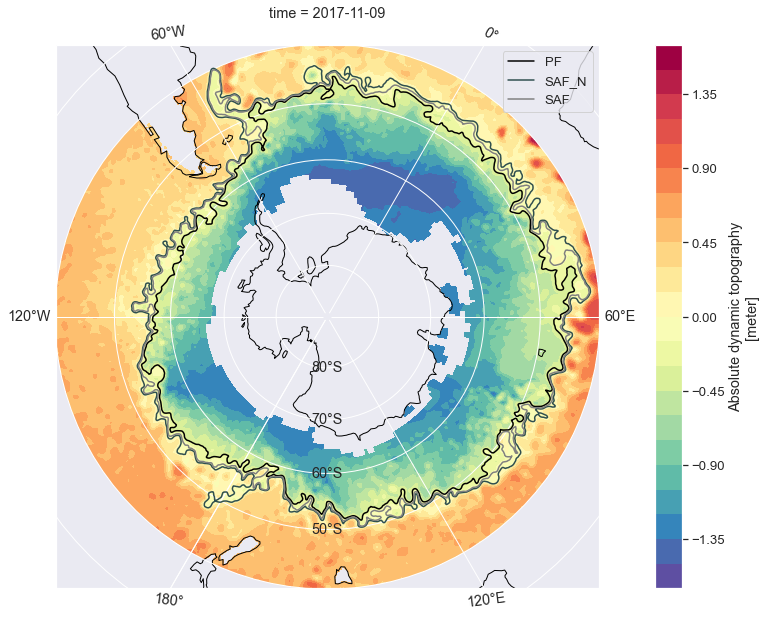

In [111]:
load_ACC_fronts('data/01_raw/SALLEE2008_SO_FRONTS/CTOH_PolarFront_weekly_1993_2018.nc', '2017-11-09', 'PF')
load_ACC_fronts('data/01_raw/SALLEE2008_SO_FRONTS/CTOH_NorthernSubantarcticFront_weekly_1993_2018.nc', '2017-11-09', 'SAF_N')
load_ACC_fronts('data/01_raw/SALLEE2008_SO_FRONTS/CTOH_SubantarcticFront_weekly_1993_2018.nc', '2017-11-09', 'SAF')

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-30))

PF = ax.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', color='black')
SAF_N = ax.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', color='darkslategray')
SAF = ax.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', color='gray')

ds_ssh_SO.adt.sel(time='2017-11-09').plot.contourf(
    transform=ccrs.PlateCarree(),
    levels=30,
    cmap='Spectral_r',
    ax=ax)

ax.coastlines()
ax.gridlines(draw_labels=True)
plt.legend()

plt.savefig(r'results\analysis\ACC_contour_Sallee_fronts.png', bbox_inches='tight', format='png')
plt.show()

### Histograms and line plots

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


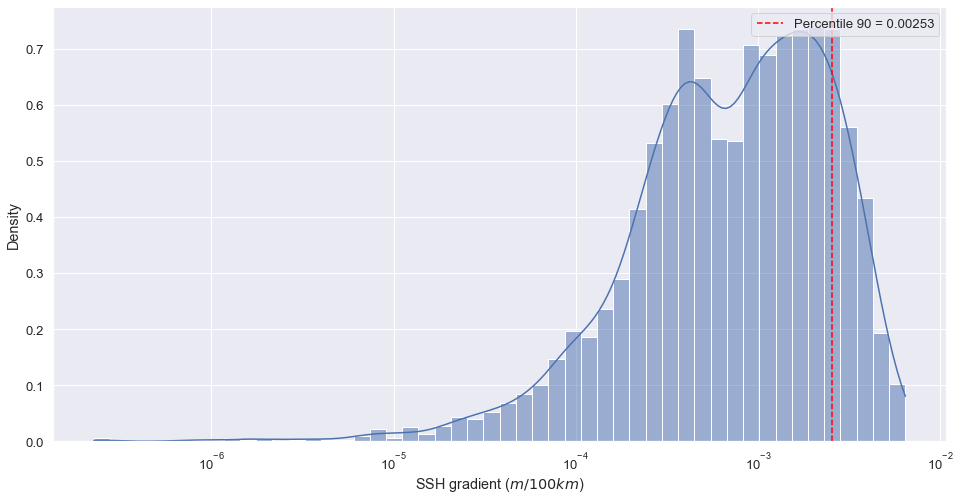

In [112]:
#Let´s plot bx along the track.
fig, ax1 = plt.subplots(figsize=(16,8))

aux = np.array(ds_ssh_drake.adt_grad_mer.dropna(dim='latitude').dropna(dim='longitude').values).flatten()
sns.histplot(data=np.abs(np.array(aux)),
    multiple='stack',
     stat='density',
     kde=True,
     bins=50,
     log_scale=True
     )

ax1.set(xlabel='SSH gradient ($m/100km$)')
ax1.axvline(np.nanpercentile(np.abs(ds_ssh_drake.adt_grad_mer),90),
    linestyle='--',
    label=str(('Percentile 90 = ') + str(np.round(np.nanpercentile(np.abs(ds_ssh_drake.adt_grad_mer), 90),5))),
    color='red'
    )

ax1.legend(loc='upper right')

In [113]:
#PF_lon_TSG = utils.utils.closest_value(utils.utils.convert_lon_center(utils.utils.np_dropna(longitude_PF).data) ,np.mean(ds_TSG.lon).values)

In [114]:
#np.where(longitude_PF.data == PF_lon_TSG)

In [115]:
#PF_lon_TSG

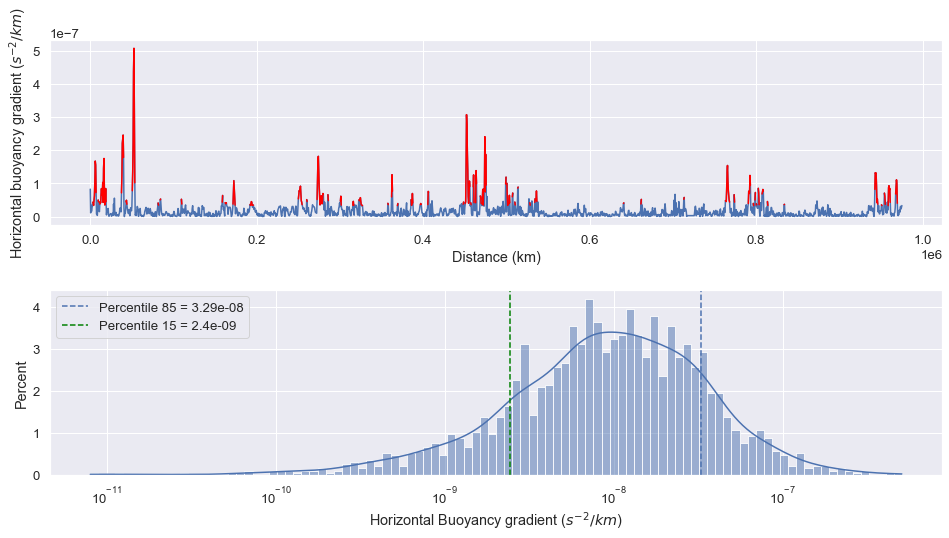

In [116]:
#Let´s plot bx along the track.
fig, (ax0, ax1) = plt.subplots(nrows=2,figsize=(16,8))
plt.subplots_adjust(hspace=0.35)

sns.lineplot(x=ds_TSG.distance_cum, 
    y=np.abs(ds_TSG.bx), 
    ax=ax0, 
    )

aux = ds_TSG.bx.where(np.abs(ds_TSG.bx.metpy.dequantify()) > np.nanpercentile(np.abs(ds_TSG.bx),85), drop=False).metpy.dequantify()
ax0.plot(aux.distance_cum, np.abs(aux),
    color='red')

sns.histplot(data=np.abs(ds_TSG.bx), 
    kde=True, 
    stat='percent', 
    log_scale=True,
    bins=100
    )

ax0.set(xlabel='Distance (km)', ylabel='Horizontal buoyancy gradient ($s^{-2}/km$)')

ax1.set(xlabel='Horizontal Buoyancy gradient ($s^{-2}/km$)')
ax1.axvline(np.nanpercentile(np.abs(ds_TSG.bx),85),
    linestyle='--',
    label=str(('Percentile 85 = ') + str(np.round(np.percentile(np.abs(ds_TSG.bx), 85),10)))
    )
ax1.axvline(np.nanpercentile(np.abs(ds_TSG.bx),15),
    linestyle='--',
    label=str(('Percentile 15 = ') + str(np.round(np.percentile(np.abs(ds_TSG.bx), 15),10)),),
    color='green'
    )

ax1.legend(loc='upper left')

plt.savefig(r'results\analysis\bx_TSG_with_threshold.png', bbox_inches='tight', format='png')
plt.show()

### Regional maps

In [117]:
# fig = plt.figure(figsize=(20,10))
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# ax.contourf(front_loc.longitude, front_loc.latitude, front_loc,
#     transform=ccrs.PlateCarree(),
#     hatches=['xx'],
#     colors='black',
#     alpha=0.1,
#     add_colorbar=False
#     )

# TSG = ax.scatter(ds_TSG.lon, ds_TSG.lat, 
#         transform=ccrs.PlateCarree(),
#         c=np.log10(np.abs(ds_TSG.bx.metpy.dequantify())),
#         cmap='coolwarm',
#         vmin=-9,
#         marker='_'
#         )

# PF = ax.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', color='black', linewidth=2)
# SAF_N = ax.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', color='darkslategray', linewidth=2)
# SAF = ax.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', color='gray', linewidth=2)

# gl = ax.gridlines(crs=ccrs.PlateCarree(), 
#     draw_labels=True,
#     linewidth=2,
#     color='gray',
#     alpha=0.5,
#     linestyle='--')

# ax.set_extent([-60,-56,-60,-54])
# ax.coastlines()

# plt.colorbar(TSG, ax=ax)
# plt.legend()

# plt.savefig(r'results\analysis\TSG_region_mixed_data.png', bbox_inches='tight', format='png')
# plt.show()

In [118]:
# fig = plt.figure(figsize=(20,10))
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# ax.contourf(front_loc.longitude, front_loc.latitude, front_loc,
#     transform=ccrs.PlateCarree(),
#     hatches=['xx'],
#     colors='black',
#     alpha=0.1,
#     add_colorbar=False
#     )

# from matplotlib import colors
# cmap =colors.ListedColormap(['white','blue','red'])
# bounds=[0,1,2]
# TSG = ax.scatter(ds_TSG.lon[0:-1], ds_TSG.lat[0:-1], 
#         transform=ccrs.PlateCarree(),
#         c=bx_cat,
#         cmap=cmap,
#         vmin=0,
#         vmax=2,
#         marker='_'
#         )

# PF = ax.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', color='black', linewidth=2)
# SAF_N = ax.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', color='darkslategray', linewidth=2)
# SAF = ax.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', color='gray', linewidth=2)

# gl = ax.gridlines(crs=ccrs.PlateCarree(), 
#     draw_labels=True,
#     linewidth=2,
#     color='gray',
#     alpha=0.5,
#     linestyle='--')



# ax.set_extent([-60,-56,-60,-54])
# ax.coastlines('10m')

# cb = plt.colorbar(TSG,
#         ax=ax,
#         ticks=[0, 1, 2],
#         drawedges=True)

# cb.outline.set_edgecolor('black')
# cb.outline.set_linewidth(1)

# cb.dividers.set_color('black')
# cb.dividers.set_linewidth(1)

# plt.legend()

# #plt.savefig(r'results\analysis\TSG_region_mixed_data_grouped.png', bbox_inches='tight', format='png')
# plt.show()

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\cartopy\mpl\geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\cartopy\mpl\geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


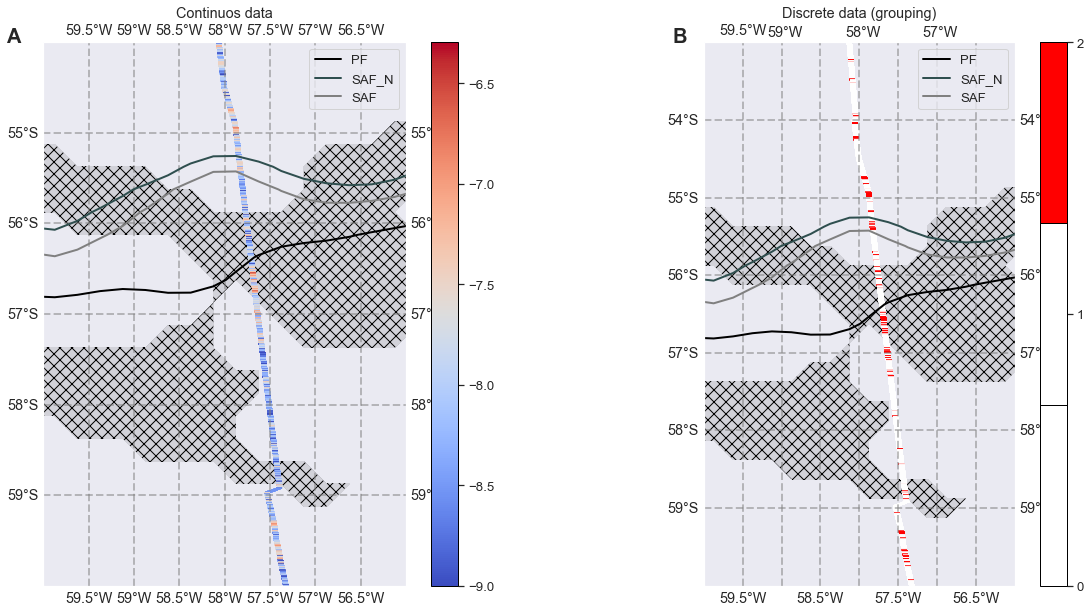

In [119]:
import string

fig =  plt.figure(figsize=(20,10))

ax0 = plt.subplot(1,2,1, projection=ccrs.PlateCarree(central_longitude=0), title='Continuos data')

ax0.text(-0.1, 1, 'A', transform=ax0.transAxes,
    fontsize=20, fontweight='bold')

ax0.contourf(front_loc.longitude, front_loc.latitude, front_loc,
    transform=ccrs.PlateCarree(),
    hatches=['xx'],
    colors='black',
    alpha=0.1,
    add_colorbar=False
    )

TSG = ax0.scatter(ds_TSG.lon, ds_TSG.lat, 
        transform=ccrs.PlateCarree(),
        c=np.log10(np.abs(ds_TSG.bx.metpy.dequantify())),
        cmap='coolwarm',
        vmin=-9,
        marker='_'
        )

PF = ax0.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', color='black', linewidth=2)
SAF_N = ax0.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', color='darkslategray', linewidth=2)
SAF = ax0.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', color='gray', linewidth=2)

GL = ax0.gridlines(crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=2,
    color='gray',
    alpha=0.5,
    linestyle='--')

ax0.set_extent([-60,-56,-60,-54])
ax0.coastlines()

cb = plt.colorbar(TSG, ax=ax0)

cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1)

cb.dividers.set_color('black')
cb.dividers.set_linewidth(1)

plt.legend()

ax1 = plt.subplot(1,2,2, projection=ccrs.PlateCarree(central_longitude=0), title='Discrete data (grouping)')

ax1.text(-0.1, 1, 'B', transform=ax1.transAxes,
    fontsize=20, fontweight='bold')

ax1.contourf(front_loc.longitude, front_loc.latitude, front_loc,
    transform=ccrs.PlateCarree(),
    hatches=['xx'],
    colors='black',
    alpha=0.1,
    add_colorbar=False
    )

from matplotlib import colors
cmap =colors.ListedColormap(['white','white','red'])
bounds=[0,1,2]
TSG = ax1.scatter(ds_TSG.lon[0:-1], ds_TSG.lat[0:-1], 
        transform=ccrs.PlateCarree(),
        c=bx_cat,
        cmap=cmap,
        vmin=0,
        vmax=2,
        marker='_'
        )

PF = ax1.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', color='black', linewidth=2)
SAF_N = ax1.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', color='darkslategray', linewidth=2)
SAF = ax1.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', color='gray', linewidth=2)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=2,
    color='gray',
    alpha=0.5,
    linestyle='--')

ax1.set_extent([-60,-56,-60,-53])
ax1.coastlines('10m')

cb = plt.colorbar(TSG,
        ax=ax1,
        ticks=[0, 1, 2],
        drawedges=True)

plt.legend()

cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1)

cb.dividers.set_color('black')
cb.dividers.set_linewidth(1)

plt.legend(loc='upper right')

plt.savefig(r'results\analysis\TSG_region_mixed_data_mean_01-oct-31-dec.png', bbox_inches='tight', format='png')
plt.show()

## KE long term reference

##### Plotting functions

In [28]:
def draw_box(ax,x0,x1,y0,y1,color='red',linewidth=1.5,linestyle='-'):

    ax.plot([x0,x1],[y0,y0],
        color=color,
        linewidth=linewidth,
        linestyle=linestyle
        )

    ax.plot([x0,x1],[y1,y1],
        color=color,
        linewidth=linewidth,
        linestyle=linestyle
        )

    ax.plot([x0,x0],[y0,y1],
        color=color,
        linewidth=linewidth,
        linestyle=linestyle
        )

    ax.plot([x1,x1],[y0,y1],
        color=color,
        linewidth=linewidth,
        linestyle=linestyle
        )

In [29]:
def plot_geostrophic_velocities(ds,
    transect_lon, transect_lat, 
    box_x0, box_x1, box_y0, box_y1, 
    savepath,
    extent=[-70,-40,-70,-50],
    plot1_title = 'Figure 1', plot2_title = 'Figure 2',
    lon_var_name='longitude', lat_var_name='latitude',
    ADT_var_name='adt', ugos_var_name='ugos', vgos_var_name='vgos',
    sla_var_name='sla', ugosa_var_name='ugosa', vgosa_var_name='vgosa'):

    from matplotlib.gridspec import GridSpec
    import cartopy.feature as cfeature

    if box_x0 < 0:
        box_x0_aux = box_x0 - 0.2
    else:
        box_x0_aux = box_x0 + 0.2
    
    if box_x1 < 0:
        box_x1_aux = box_x1 + 0.2
    else:
        box_x1_aux = box_x1 - 0.2

    box_y0_aux = box_y0 - 0.2
    box_y1_aux = box_y1 + 0.2

    ds_ssh_box = ds.sel(longitude = slice(box_x0_aux, box_x1_aux), latitude = slice(box_y0_aux, box_y1_aux))

    fig = plt.figure(figsize=(10,20))
    gs = GridSpec(nrows=2, ncols=1, hspace=0.1, wspace=0.1)

    #Plot 1:
    ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))

    ax0.set_extent(extent)

    adt0 = ax0.contourf(
        ds[lon_var_name],
        ds[lat_var_name],
        ds[ADT_var_name],
        cmap='Spectral_r',
        levels=30)

    gl0 = ax0.gridlines(crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=2,
        color='gray',
        alpha=0.5,
        linestyle='--')

    x = np.array(ds[lon_var_name])
    y = np.array(ds[lat_var_name])
    u = np.array(ds[ugos_var_name])
    v = np.array(ds[vgos_var_name])

    magnitude = np.sqrt(u**2 + v**2)
    #magnitude_norm = (magnitude - np.nanmin(magnitude))/(np.nanmax(magnitude) - np.nanmin(magnitude))

    quiv0 = ax0.quiver(x, y, u, v, 
        #magnitude,
        #cmap='autumn_r'
        )

    ax0.plot(
        transect_lon,
        transect_lat,
        c='purple',
        linewidth=2
    )

    PF = ax0.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', linewidth=2, color='black')
    SAF_N = ax0.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', linewidth=2, color='darkgray')
    SAF = ax0.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', linewidth=2, color='white')

    ax0.legend()

    plt.colorbar(adt0, 
        ax=ax0,
        label = 'Absolute dynamic topography [m]',
        orientation='horizontal',
        pad=0.05    
        )

    ax0.add_feature(cfeature.LAND, zorder=1, edgecolor='black')
    ax0.coastlines()

    ax0.set_title(plot1_title)

    #regional box
    draw_box(ax0,box_x0,box_x1,box_y0,box_y1)

    ax1 = fig.add_axes([0.75, 0.48, 0.3, 0.5], projection=ccrs.PlateCarree(central_longitude=0))
    ax1.set_extent([box_x0,box_x1,box_y0,box_y1])

    adt1 = ax1.contourf(
        ds_ssh_box[lon_var_name],
        ds_ssh_box[lat_var_name],
        ds_ssh_box[ADT_var_name],
        cmap='Spectral_r',
        levels=30)

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=2,
        color='gray',
        alpha=0.5,
        linestyle='--')
    gl1.top_labels=False
    gl1.left_labels=False

    x_box = np.array(ds_ssh_box[lon_var_name])
    y_box = np.array(ds_ssh_box[lat_var_name])
    u_box = np.array(ds_ssh_box[ugos_var_name])
    v_box = np.array(ds_ssh_box[vgos_var_name])

    quiv1 = ax1.quiver(x_box, y_box, u_box, v_box,
        color='black',
        scale=1.5,
        #linewidth=1.5,
        )

    from matplotlib import colors
    cmap =colors.ListedColormap(['white','white','red'])
    bounds=[0,1,2]
    TSG = ax1.scatter(ds_TSG.lon[0:-1], ds_TSG.lat[0:-1], 
            transform=ccrs.PlateCarree(),
            c=bx_cat,
            cmap=cmap,
            vmin=0,
            vmax=2,
            marker='_'
            )

    PF = ax1.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', linewidth=2, color='black')
    SAF_N = ax1.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', linewidth=2, color='darkgray')
    SAF = ax1.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', linewidth=2, color='white')

    cb3 = plt.colorbar(adt1, 
    ax=ax1,
    orientation='vertical',
    fraction=0.055,
    pad=0.20    
    )

    ax1.outline_patch.set_edgecolor('red')
    ax1.outline_patch.set_linestyle('-')
    ax1.outline_patch.set_linewidth(1)

    #Plot2:
    ax2 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=0))

    ax2.set_extent(extent)

    sla2 = ax2.contourf(
        ds[lon_var_name],
        ds[lat_var_name],
        ds[sla_var_name],
        cmap='Spectral_r',
        levels=30)

    gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=2,
        color='gray',
        alpha=0.5,
        linestyle='--')

    x_a = np.array(ds[lon_var_name])
    y_a = np.array(ds[lat_var_name])
    u_a = np.array(ds[ugosa_var_name])
    v_a = np.array(ds[vgosa_var_name])

    magnitude_a = np.sqrt(u_a**2 + v_a**2)
    magnitude_a_norm = (magnitude - np.nanmin(magnitude_a))/(np.nanmax(magnitude_a) - np.nanmin(magnitude_a))

    quiv2 = ax2.quiver(x_a, y_a, u_a, v_a, 
        #magnitude_a,
        #cmap='autumn_r'
        )

    ax2.plot(
        transect_lon,
        transect_lat,
        c='purple',
        linewidth=2
    )

    PF = ax2.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', linewidth=2, color='black')
    SAF_N = ax2.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', linewidth=2, color='darkgray')
    SAF = ax2.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', linewidth=2, color='white')

    ax2.legend()

    plt.colorbar(sla2, 
        ax=ax2,
        label = 'Sea Level Anomaly [m]',
        orientation='horizontal',
        pad=0.05)

    ax2.add_feature(cfeature.LAND, zorder=1, edgecolor='black')
    ax2.coastlines()

    ax2.set_title(plot2_title)

    #regional box
    draw_box(ax2,box_x0,box_x1,box_y0,box_y1)

    ax3 = fig.add_axes([0.75, 0.085, 0.3, 0.5], projection=ccrs.PlateCarree(central_longitude=0))
    ax3.set_extent([box_x0,box_x1,box_y0,box_y1])

    sla3 = ax3.contourf(
        ds_ssh_box[lon_var_name],
        ds_ssh_box[lat_var_name],
        ds_ssh_box[sla_var_name],
        cmap='Spectral_r',
        levels=30)

    gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=2,
        color='gray',
        alpha=0.5,
        linestyle='--')
    gl3.top_labels=False
    gl3.left_labels=False

    x_a_box = np.array(ds_ssh_box[lon_var_name])
    y_a_box = np.array(ds_ssh_box[lat_var_name])
    u_a_box = np.array(ds_ssh_box[ugosa_var_name])
    v_a_box = np.array(ds_ssh_box[vgosa_var_name])

    quiv3 = ax3.quiver(x_a_box, y_a_box, u_a_box, v_a_box,
        color='black',
        scale=1.5,
        #linewidth=1.5,
        )

    from matplotlib import colors
    cmap =colors.ListedColormap(['white','white','red'])
    bounds=[0,1,2]
    TSG = ax3.scatter(ds_TSG.lon[0:-1], ds_TSG.lat[0:-1], 
            transform=ccrs.PlateCarree(),
            c=bx_cat,
            cmap=cmap,
            vmin=0,
            vmax=2,
            marker='_'
            )

    PF = ax3.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', linewidth=2, color='black')
    SAF_N = ax3.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', linewidth=2, color='darkgray')
    SAF = ax3.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', linewidth=2, color='white')

    cb3 = plt.colorbar(sla3, 
    ax=ax3,
    orientation='vertical',
    fraction=0.055,
    pad=0.20    
    )

    ax3.outline_patch.set_edgecolor('red')
    ax3.outline_patch.set_linestyle('-')
    ax3.outline_patch.set_linewidth(1)

    plt.savefig(savepath, bbox_inches='tight', format='png')
    plt.show()

In [30]:
def plot_KE(ds, 
    transect_lon, transect_lat, 
    box_x0, box_x1, box_y0, box_y1, 
    savepath, 
    extent=[-70,-40,-70,-50],
    plot1_title = 'Figure 1', plot2_title = 'Figure 2',
    lon_var_name='longitude', lat_var_name='latitude', KE_var_name='KE', EKE_var_name='EKE'):

    from matplotlib.gridspec import GridSpec
    import cartopy.feature as cfeature
    import cmocean as cmocean

    if box_x0 < 0:
        box_x0_aux = box_x0 - 0.2
    else:
        box_x0_aux = box_x0 + 0.2
    
    if box_x1 < 0:
        box_x1_aux = box_x1 + 0.2
    else:
        box_x1_aux = box_x1 - 0.2

    box_y0_aux = box_y0 - 0.2
    box_y1_aux = box_y1 + 0.2

    ds_ssh_box = ds.sel(longitude = slice(box_x0_aux, box_x1_aux), latitude = slice(box_y0_aux, box_y1_aux))

    fig = plt.figure(figsize=(10,20))
    gs = GridSpec(nrows=2, ncols=1, hspace=0.1, wspace=0.1)

    #Plot 1: Total KE
    ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))

    ax0.set_extent(extent)

    ke0 = ax0.contourf(
        ds[lon_var_name],
        ds[lat_var_name],
        ds[KE_var_name],
        cmap='Spectral_r',
        vmin=np.min(ds[KE_var_name]),
        vmax=np.max(ds[KE_var_name]),
        levels=30)

    gl0 = ax0.gridlines(crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=2,
        color='gray',
        alpha=0.5,
        linestyle='--'
        )

    ax0.plot(
        transect_lon,
        transect_lat,
        c='purple',
        linewidth=2
        )

    PF = ax0.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', linewidth=2, color='black')
    SAF_N = ax0.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', linewidth=2, color='darkgray')
    SAF = ax0.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', linewidth=2, color='white')

    ax0.legend()

    cb0 = plt.colorbar(ke0, 
        ax=ax0,
        label = 'Total Kinetic Energy [$cm^{2}/s^{2}$]',
        orientation='horizontal',
        pad=0.05    
        )

    ax0.add_feature(cfeature.LAND, zorder=1, edgecolor='black')
    ax0.coastlines()

    ax0.set_title(plot1_title)

    #regional box
    draw_box(ax0,box_x0,box_x1,box_y0,box_y1)

    ax1 = fig.add_axes([0.75, 0.48, 0.3, 0.5], projection=ccrs.PlateCarree(central_longitude=0))
    ax1.set_extent([box_x0,box_x1,box_y0,box_y1])

    ke1 = ax1.contourf(
        ds_ssh_box[lon_var_name],
        ds_ssh_box[lat_var_name],
        ds_ssh_box[KE_var_name],
        cmap=cmocean.cm.balance,
        vmin = np.min(ds_ssh_box[KE_var_name]),
        vmax = np.max(ds_ssh_box[KE_var_name]),
        levels=30
        )

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=2,
        color='gray',
        alpha=0.5,
        linestyle='--'
        )
    gl1.top_labels=False
    gl1.left_labels=False

    from matplotlib import colors
    cmap =colors.ListedColormap(['white','white','red'])
    bounds=[0,1,2]
    TSG = ax1.scatter(ds_TSG.lon[0:-1], ds_TSG.lat[0:-1], 
            transform=ccrs.PlateCarree(),
            c=bx_cat,
            cmap=cmap,
            vmin=0,
            vmax=2,
            marker='_'
            )

    PF = ax1.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', linewidth=2, color='black')
    SAF_N = ax1.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', linewidth=2, color='darkgray')
    SAF = ax1.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', linewidth=2, color='white')

    cb1 = plt.colorbar(ke1, 
        ax=ax1,
        orientation='vertical',
        fraction=0.055,
        pad=0.20    
        )

    ax1.outline_patch.set_edgecolor('red')
    ax1.outline_patch.set_linestyle('-')
    ax1.outline_patch.set_linewidth(1)

    #Plot2:
    ax2 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=0))

    ax2.set_extent(extent)

    eke2 = ax2.contourf(
        ds[lon_var_name],
        ds[lat_var_name],
        ds[EKE_var_name],
        cmap='Spectral_r',
        levels=30
        )

    gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=2,
        color='gray',
        alpha=0.5,
        linestyle='--'
        )

    ax2.plot(
        transect_lon,
        transect_lat,
        c='purple',
        linewidth=2
    )

    PF = ax2.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', linewidth=2, color='black')
    SAF_N = ax2.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', linewidth=2, color='darkgray')
    SAF = ax2.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', linewidth=2, color='white')

    ax2.legend()

    plt.colorbar(eke2, 
        ax=ax2,
        label = 'Eddy Kinetic Energy [$cm^{2}/s^{2}$]',
        orientation='horizontal',
        pad=0.05)

    ax2.add_feature(cfeature.LAND, zorder=1, edgecolor='black')
    ax2.coastlines()

    ax2.set_title(plot2_title)

    #regional box
    draw_box(ax2,box_x0,box_x1,box_y0,box_y1)

    ax3 = fig.add_axes([0.75, 0.085, 0.3, 0.5], projection=ccrs.PlateCarree(central_longitude=0))
    ax3.set_extent([box_x0,box_x1,box_y0,box_y1])

    eke3 = ax3.contourf(
        ds_ssh_box[lon_var_name],
        ds_ssh_box[lat_var_name],
        ds_ssh_box[EKE_var_name],
        cmap=cmocean.cm.balance,
        vmin = np.min(ds_ssh_box[EKE_var_name]),
        vmax = np.max(ds_ssh_box[EKE_var_name]),
        levels=30
        )

    gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), 
        draw_labels=True,
        linewidth=2,
        color='gray',
        alpha=0.5,
        linestyle='--')
    gl3.top_labels=False
    gl3.left_labels=False

    from matplotlib import colors
    cmap =colors.ListedColormap(['white','white','red'])
    bounds=[0,1,2]
    TSG = ax3.scatter(ds_TSG.lon[0:-1], ds_TSG.lat[0:-1], 
            transform=ccrs.PlateCarree(),
            c=bx_cat,
            cmap=cmap,
            vmin=0,
            vmax=2,
            marker='_'
            )

    PF = ax3.plot(longitude_PF, latitude_PF, transform=ccrs.PlateCarree(), label='PF', linewidth=2, color='black')
    SAF_N = ax3.plot(longitude_SAF_N, latitude_SAF_N,transform=ccrs.PlateCarree(), label='SAF_N', linewidth=2, color='darkgray')
    SAF = ax3.plot(longitude_SAF, latitude_SAF,transform=ccrs.PlateCarree(), label='SAF', linewidth=2, color='white')

    cb3 = plt.colorbar(eke3, 
        ax=ax3,
        orientation='vertical',
        fraction=0.055,
        pad=0.20    
        )

    ax3.outline_patch.set_edgecolor('red')
    ax3.outline_patch.set_linestyle('-')
    ax3.outline_patch.set_linewidth(1)

    plt.savefig(savepath, bbox_inches='tight', format='png')
    plt.show()

### Loading data

In [31]:
#Start year and end year
START_YEAR  = 2017
END_YEAR    = 2019 #NOT INCLUDED
NUMBER_YEAR = 2


years = range(START_YEAR, END_YEAR)
months = ['%.2d' % i for i in range(1,13)]
number_years = range(NUMBER_YEAR)

#Input paths of the files
base_adt_path = 'data/01_raw/AVISO/SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047/dataset-duacs-rep-global-merged-allsat-phy-l4' #
#adt_file_name_base = 'dt_global_twosat_phy_l4_'


#Main file reading algorithm. Multifile reader of xarray which concanates the read files (loading through dask). Additional loop and concanating of each month and years (THIS IS JUST FOR THE FIRST YEAR, CHANGE INDEX OF YEARS (MAY HAVE TO LOOP THROUGH))
ds_adt = xr.concat([xr.concat([[xr.open_mfdataset(base_adt_path + '/' + str(i_year) + '/' + i_month + '/' + '*.nc', parallel = True) for i_month in months] for i_year in years][n_year], dim='time') for n_year in number_years], dim='time')

#Center longitude format to Atlantic.
ds_adt = ds_adt.assign_coords(longitude=(((ds_adt.longitude + 180) % 360)-180)).sortby('longitude')
ds_adt.longitude.attrs = {
    'long_name': 'Longitude',
    'standard_name': 'longitude',
    'units': 'degrees_east',
    'bounds': 'lon_bnds',
    'axis': 'X',
    'valid_max': 179.9375,
    'valid_min': -179.9375,
    '_CoordinateAxisType': 'Lon'}

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\xarray\core\indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\xarray\core\indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.arr

In [32]:
ds_adt

<xarray.Dataset>
Dimensions:    (time: 730, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * nv         (nv) int32 0 1
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2017-01-01T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2017-01-01T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

### 3 months average

In [33]:
ds_ssh_drake_summer = ds_adt.sel(longitude = slice(-70, -40), latitude = slice(-70,-50)).sel(time=slice('2017-10-01','2017-12-31')).mean('time', keep_attrs = True)


#### Geostrophic velocities

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:145: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_edgecolor('red')
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:146: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linestyle('-')
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:147: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] o

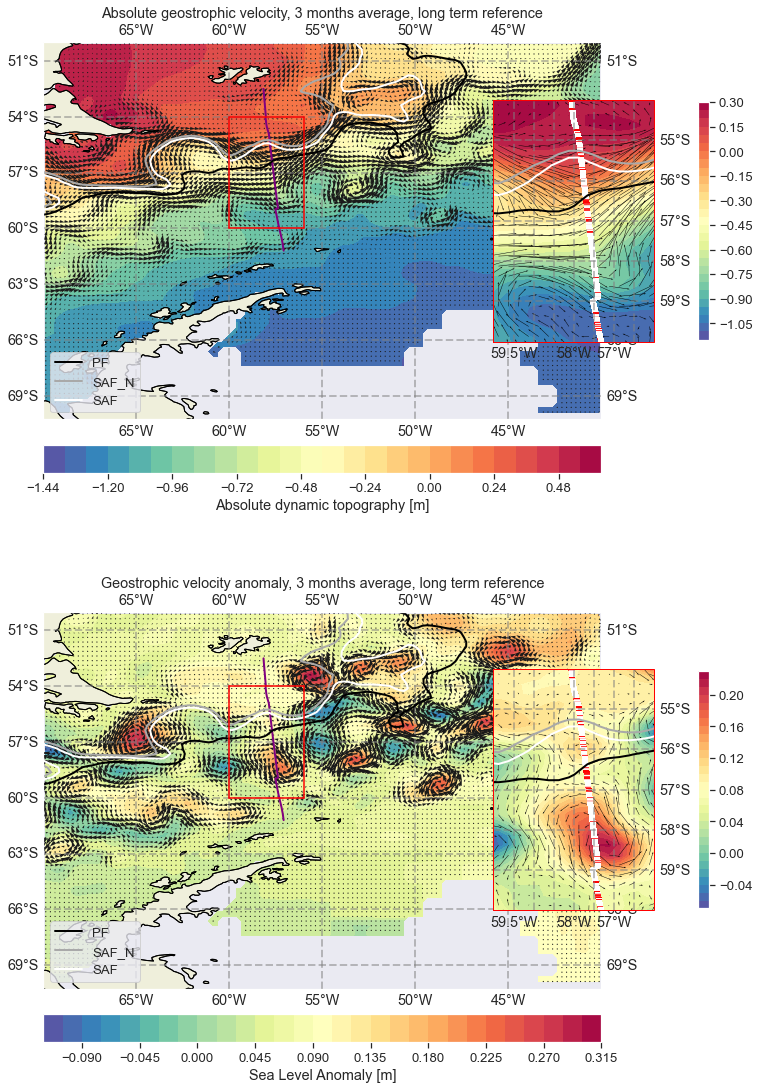

In [34]:
# comment out because it takes long to load, but good code! 
plot_geostrophic_velocities(ds_ssh_drake_summer, ds_TSG.lon, ds_TSG.lat,
     -60,-56,-60,-54, 
     savepath= r'results\analysis\Ugos-a_3months-mean_longterm-reference.png',
     plot1_title='Absolute geostrophic velocity, 3 months average, long term reference', 
     plot2_title='Geostrophic velocity anomaly, 3 months average, long term reference')

#### KE

In [35]:
ds_ssh_drake_summer['KE'] = 0.5*(((ds_ssh_drake.ugos*100)**2)+((ds_ssh_drake.vgos*100)**2))
ds_ssh_drake_summer['EKE'] = 0.5*(((ds_ssh_drake.ugosa*100)**2)+((ds_ssh_drake.vgosa*100)**2))

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/1837832175.py:127: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_edgecolor('red')
C:\Users\gian_\AppData\Loc

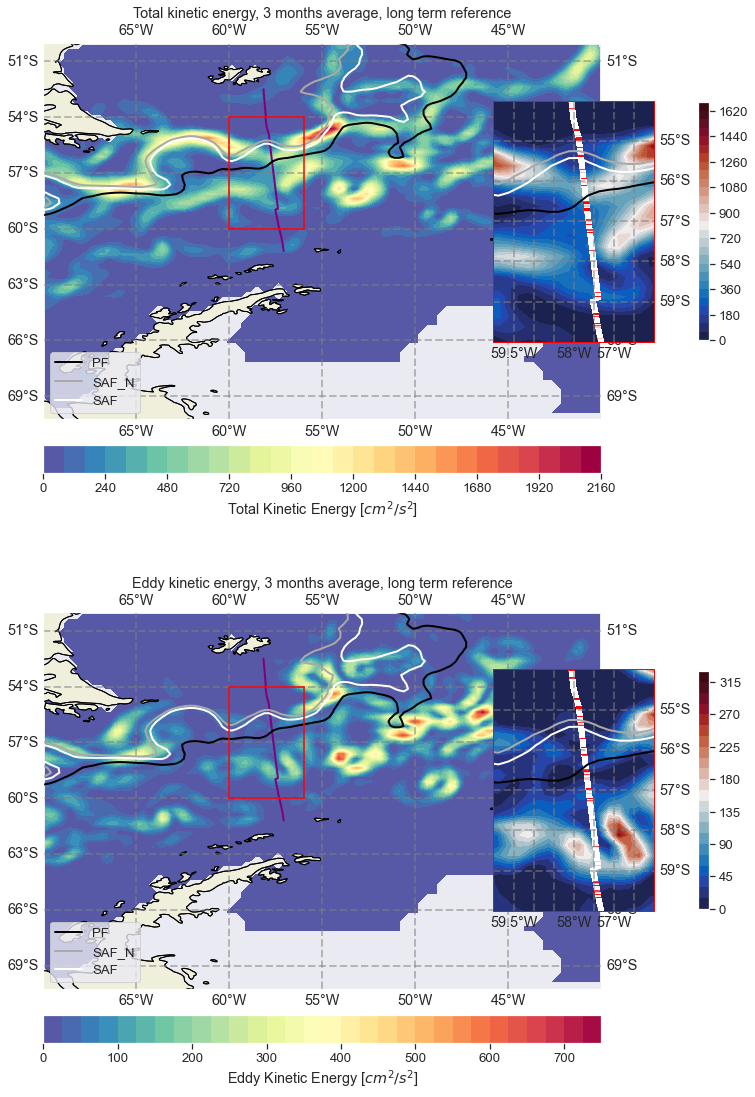

In [36]:
# comment out because it takes long to load, but good code! 
plot_KE(ds_ssh_drake_summer, ds_TSG.lon, ds_TSG.lat,
     -60,-56,-60,-54, 
     savepath= r'results\analysis\E-KE_3months-mean_longterm-reference.png',
     plot1_title='Total kinetic energy, 3 months average, long term reference', 
     plot2_title='Eddy kinetic energy, 3 months average, long term reference')

### Cruise week average

In [37]:
ds_ssh_drake_cruise = ds_adt.sel(longitude = slice(-70, -40), latitude = slice(-70,-50)).sel(time=slice('2017-11-07','2017-11-13')).mean('time', keep_attrs = True)

#### Geostrophic velocities

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:145: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_edgecolor('red')
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:146: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linestyle('-')
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:147: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] o

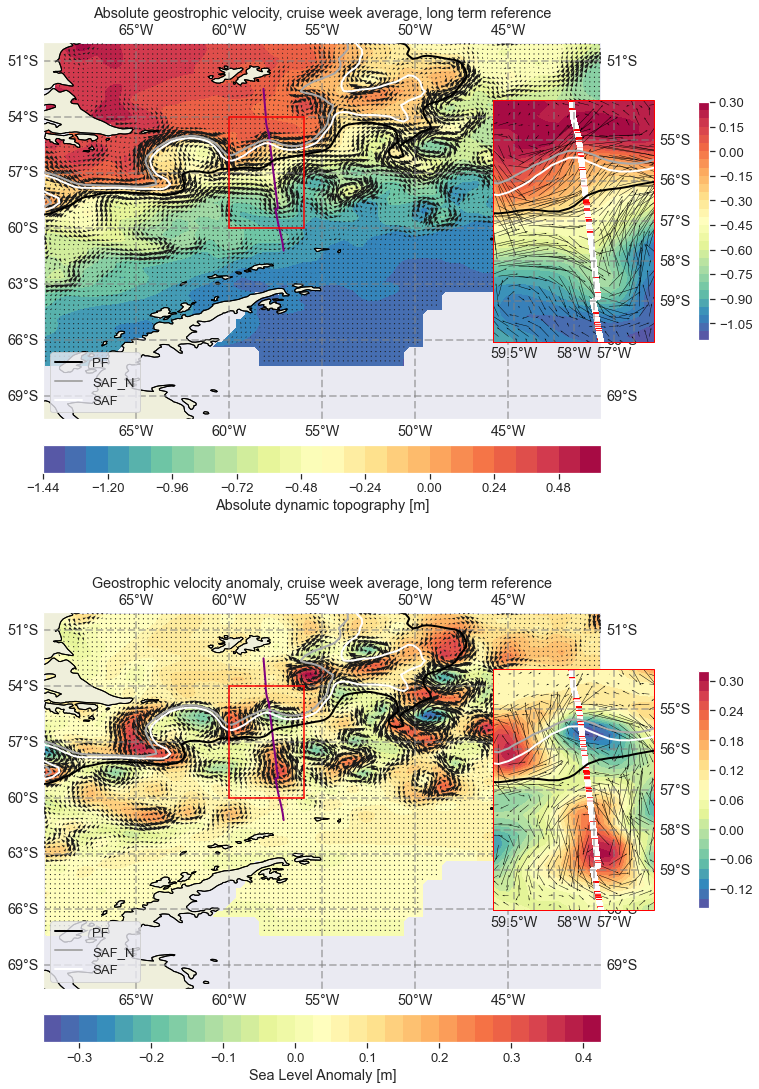

In [38]:
# comment out because it takes long to load, but good code! 
plot_geostrophic_velocities(ds_ssh_drake_cruise, ds_TSG.lon, ds_TSG.lat,
     -60,-56,-60,-54, 
     savepath= r'results\analysis\Ugos-a_cruiseweek-mean_longterm-reference.png',
     plot1_title='Absolute geostrophic velocity, cruise week average, long term reference', 
     plot2_title='Geostrophic velocity anomaly, cruise week average, long term reference')

#### KE

In [39]:
ds_ssh_drake_cruise['KE'] = 0.5*(((ds_ssh_drake_cruise.ugos*100)**2)+((ds_ssh_drake_cruise.vgos*100)**2))
ds_ssh_drake_cruise['EKE'] = 0.5*(((ds_ssh_drake_cruise.ugosa*100)**2)+((ds_ssh_drake_cruise.vgosa*100)**2))

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/1837832175.py:127: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_edgecolor('red')
C:\Users\gian_\AppData\Loc

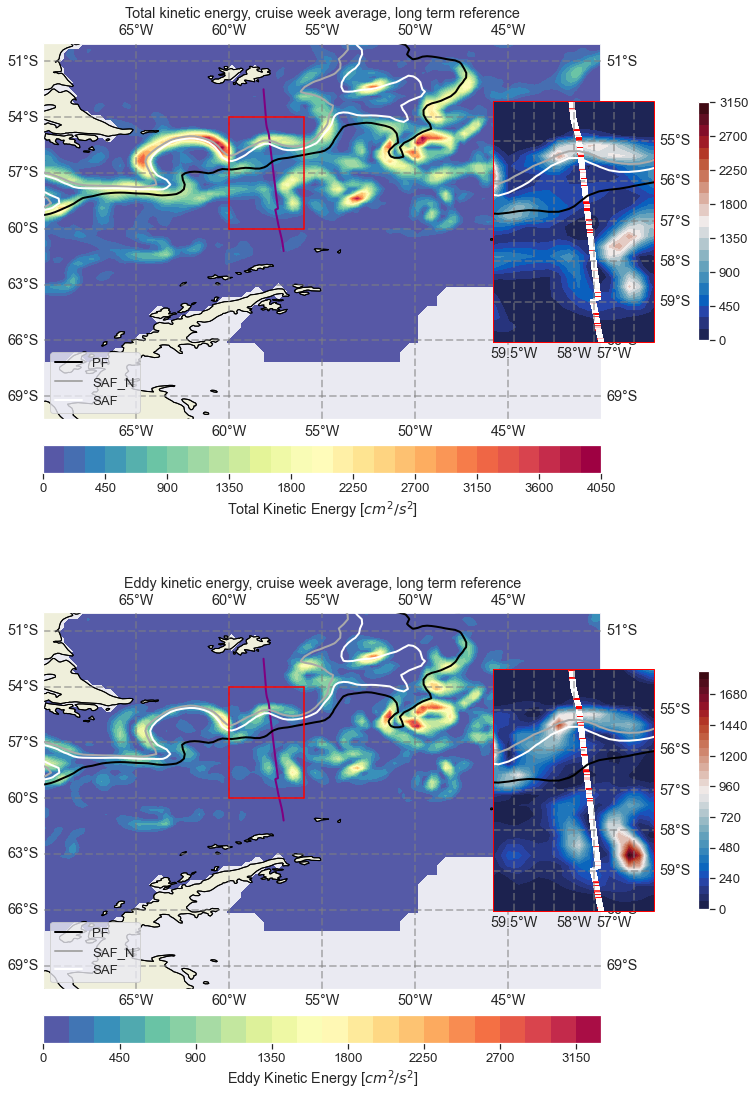

In [40]:
# comment out because it takes long to load, but good code! 
plot_KE(ds_ssh_drake_cruise, ds_TSG.lon, ds_TSG.lat,
     -60,-56,-60,-54, 
     savepath= 'results/analysis/E-KE_cruiseweek-mean_longterm-reference.png',
     plot1_title='Total kinetic energy, cruise week average, long term reference', 
     plot2_title='Eddy kinetic energy, cruise week average, long term reference')

## KE 3 months reference

### Calculations and explanation

In [41]:
# In our dataset we have got our geostrophic velocities (ugos, vgos)
# We can take the average of these over a certain time period to obtain a mean geostrophic field, considering it our reference field.
# <ugos>_3months, <vgos>_3months
# These values are our mean field in the decomposition of our velocities: 
# U = <u> + u'
# V = <v> + v'
# from this:
# u' = U - <u>
# v' = V - <v>
# considering
# U = ugos , V = vgos  --> daily total geostrophic velocities
# <u>_3months , <v>_3months --> mean geostrophic velocities
# u' = ugos - <u>_3months , v' = vgos - <v>_3months 

# EKE = 0.5((u')**2 +(v')**2)

In [42]:
ds_drake_2 = ds_adt.sel(longitude = slice(-70, -40), latitude = slice(-70,-50))

In [43]:
ds_drake_2

<xarray.Dataset>
Dimensions:    (time: 730, latitude: 80, nv: 2, longitude: 120)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * latitude   (latitude) float32 -69.88 -69.62 -69.38 ... -50.62 -50.38 -50.12
  * longitude  (longitude) float32 -69.88 -69.62 -69.38 ... -40.62 -40.38 -40.12
  * nv         (nv) int32 0 1
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(1, 80, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(1, 120, 2), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2017-01-01T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2017-01-01T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [44]:
u_meansummer_2 = ds_drake_2.ugos.sel(time=slice('2017-10-01','2017-12-31')).mean('time',keep_attrs=True)
v_meansummer_2 = ds_drake_2.vgos.sel(time=slice('2017-10-01','2017-12-31')).mean('time',keep_attrs=True)

In [45]:
ds_drake_2['u_a'] = ds_drake_2.ugos - u_meansummer_2
ds_drake_2['v_a'] = ds_drake_2.vgos - v_meansummer_2

In [47]:
ds_drake_2['KE'] = 0.5*((ds_drake_2.ugos*100)**2 + (ds_drake_2.vgos*100)**2) #*100 to have cm2/s2
ds_drake_2['EKE'] = 0.5*((ds_drake_2['u_a']*100)**2 + (ds_drake_2['v_a']*100)**2) #*100 to have cm2/s2

In [48]:
ds_drake_2

<xarray.Dataset>
Dimensions:    (time: 730, latitude: 80, nv: 2, longitude: 120)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * latitude   (latitude) float32 -69.88 -69.62 -69.38 ... -50.62 -50.38 -50.12
  * longitude  (longitude) float32 -69.88 -69.62 -69.38 ... -40.62 -40.38 -40.12
  * nv         (nv) int32 0 1
Data variables: (12/14)
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(1, 80, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(1, 120, 2), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    ...         ...
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    u_a        (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    v_a        (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    KE         (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
    EKE        (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2017-01-01T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2017-01-01T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

### 3 months average

In [49]:
ds_drake_2_summer = ds_drake_2.sel(time=slice('2017-10-01','2017-12-31')).mean('time',keep_attrs=True)

#### Geostrophic velocities

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:145: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_edgecolor('red')
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:146: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linestyle('-')
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:147: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] o

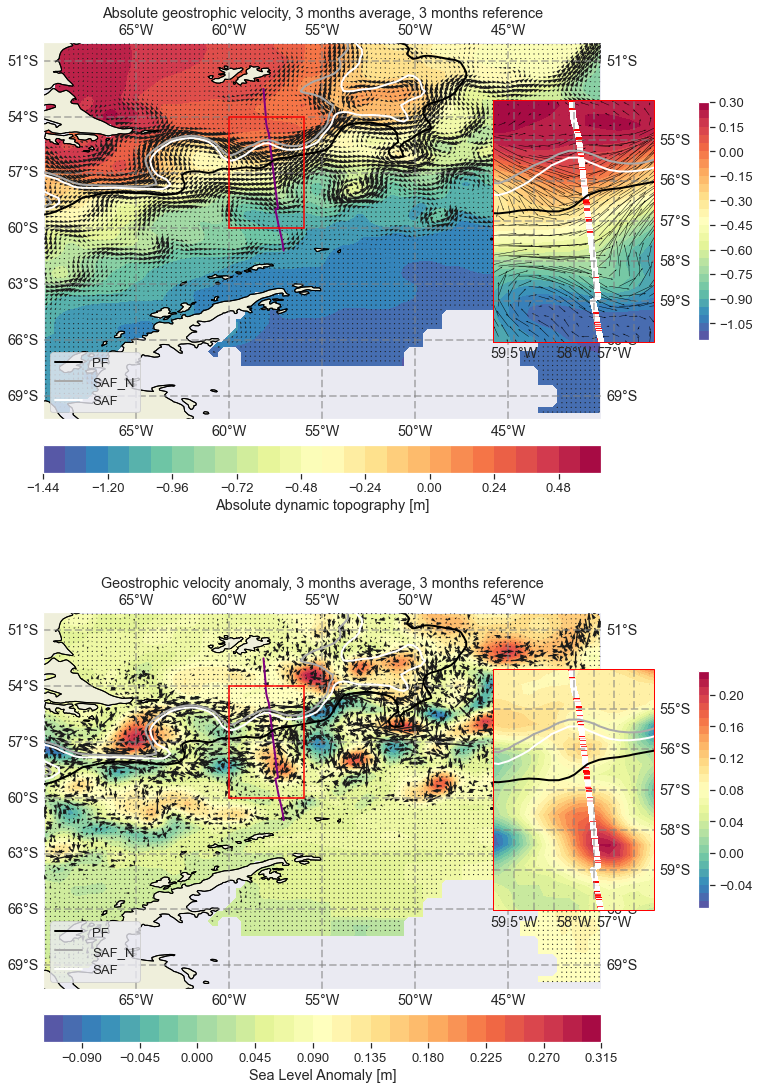

In [50]:
# comment out because it takes long to load, but good code! 
plot_geostrophic_velocities(ds_drake_2_summer, ds_TSG.lon, ds_TSG.lat,
     -60,-56,-60,-54, 
     savepath= r'results\analysis\Ugos-a_3months-mean_3months-reference.png',
     plot1_title='Absolute geostrophic velocity, 3 months average, 3 months reference', 
     plot2_title='Geostrophic velocity anomaly, 3 months average, 3 months reference',
     ugosa_var_name='u_a', vgosa_var_name='v_a')

#### KE and EKE

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/1837832175.py:127: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_edgecolor('red')
C:\Users\gian_\AppData\Loc

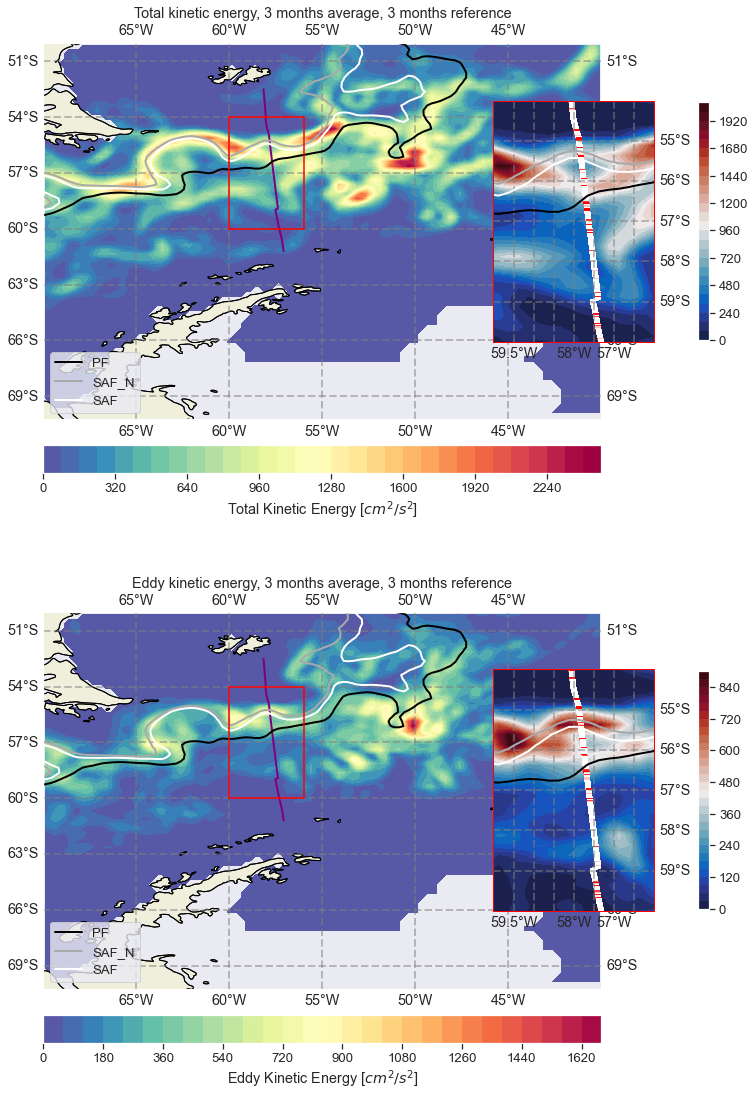

In [51]:
# comment out because it takes long to load, but good code! 
plot_KE(ds_drake_2_summer, ds_TSG.lon, ds_TSG.lat,
     -60,-56,-60,-54, 
     savepath= r'results\analysis\E-KE_3months-mean_3months-reference.png',
     plot1_title='Total kinetic energy, 3 months average, 3 months reference', 
     plot2_title='Eddy kinetic energy, 3 months average, 3 months reference')

### Cruise week average

In [52]:
ds_drake_2_cruise = ds_drake_2.sel(time=slice('2017-11-07','2017-11-13')).mean('time',keep_attrs=True)

#### Geostrophic velocities

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:145: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_edgecolor('red')
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:146: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linestyle('-')
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/3593070298.py:147: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] o

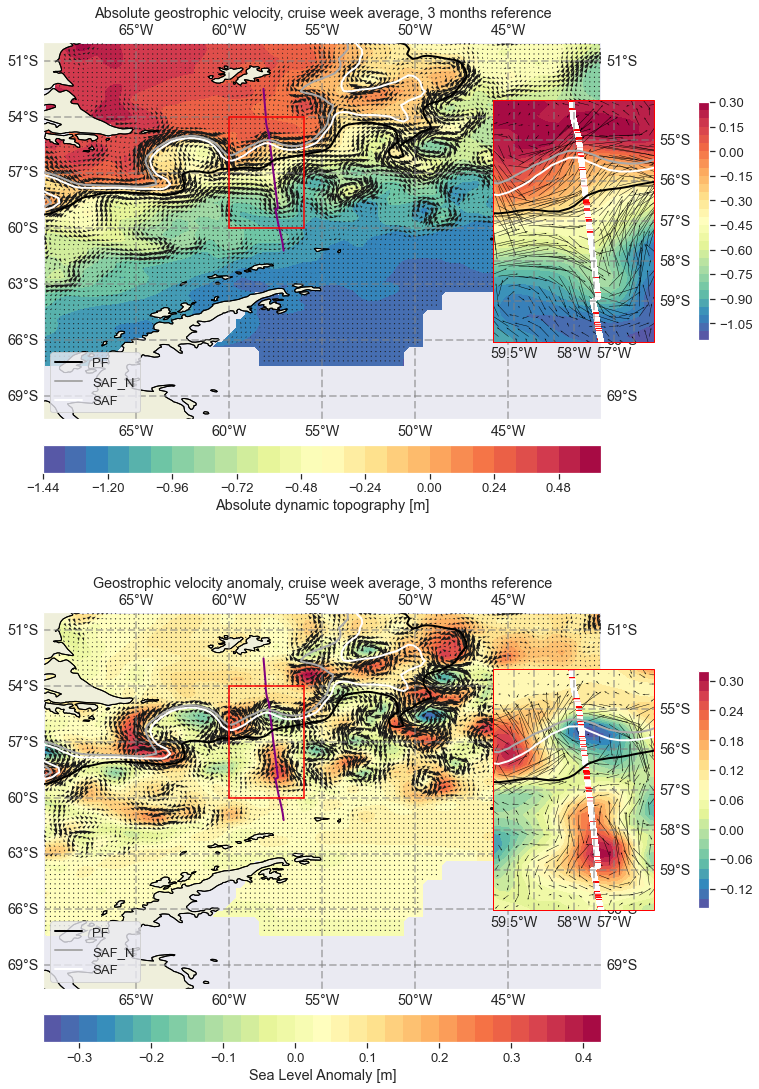

In [53]:
# comment out because it takes long to load, but good code! 
plot_geostrophic_velocities(ds_drake_2_cruise, ds_TSG.lon, ds_TSG.lat,
     -60,-56,-60,-54, 
     savepath= r'results\analysis\Ugos-a_cruise-mean_3months-reference.png',
     plot1_title='Absolute geostrophic velocity, cruise week average, 3 months reference', 
     plot2_title='Geostrophic velocity anomaly, cruise week average, 3 months reference',
     ugosa_var_name='u_a', vgosa_var_name='v_a')

#### KE and EKE

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\gian_\AppData\Local\Temp/ipykernel_43052/1837832175.py:127: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_edgecolor('red')
C:\Users\gian_\AppData\Loc

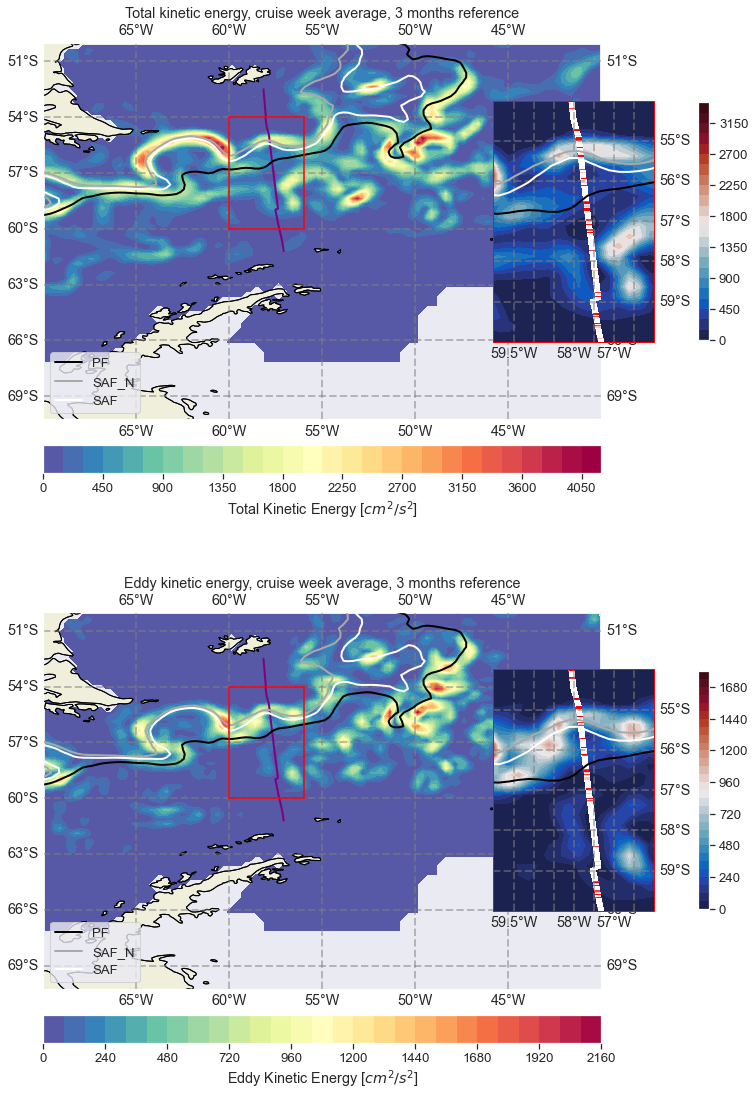

In [54]:
# comment out because it takes long to load, but good code! 
plot_KE(ds_drake_2_cruise, ds_TSG.lon, ds_TSG.lat,
     -60,-56,-60,-54, 
     savepath= r'results\analysis\E-KE_cruise-mean_3months-reference.png',
     plot1_title='Total kinetic energy, cruise week average, 3 months reference', 
     plot2_title='Eddy kinetic energy, cruise week average, 3 months reference')

### Complicated methodology of recalculating geostrophic velocities (too much work right now)

In [55]:
ds_ssh_N = ds_adt #simply renaming ds to track the time period.
# Time period N = full given time period of data
# Time period P = time period I am looking for
# Formula:
# SLA_P = SLA_N - SLA_N_meanP
# SLA_P = sea level anomaly of new reference time period
# SLA_N = sea level anomaly of old reference time period
# SLA_N_meanP = mean over the new reference time period of sea level anomaly of old reference time period 


In [56]:
ds_ssh_drake_summer = ds_adt.sel(longitude = slice(-70, -40), latitude = slice(-70,-50)).sel(time=slice('2017-10-01','2017-12-31')).mean('time', keep_attrs = True)

In [57]:
SLA_N = ds_ssh_N.sla
SLA_N_meanP = SLA_N.sel(time=slice('2017-10-01','2017-12-31')).mean('time',keep_attrs=True)
SLA_P = SLA_N - SLA_N_meanP
ds_P = SLA_P.to_dataset()

In [58]:
ds_P_drake = ds_P.sel(longitude= slice(-70,-40), latitude = slice(-70,-50))

In [59]:
ds_adt

<xarray.Dataset>
Dimensions:    (time: 730, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * nv         (nv) int32 0 1
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2017-01-01T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2017-01-01T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [60]:
ds_P_drake

<xarray.Dataset>
Dimensions:    (time: 730, latitude: 80, longitude: 120)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * latitude   (latitude) float32 -69.88 -69.62 -69.38 ... -50.62 -50.38 -50.12
  * longitude  (longitude) float32 -69.88 -69.62 -69.38 ... -40.62 -40.38 -40.12
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 80, 120), meta=np.ndarray>

##### trial, not relevant. shows that ADT is independent of time reference (kind of, not perfect, but not necessary to proceed)

In [61]:
ds_ssh_drake = ds_adt.sel(longitude = slice(-70, -40), latitude = slice(-70,-50))

In [62]:
ds_ssh_drake_summer = ds_adt.sel(longitude = slice(-70, -40), latitude = slice(-70,-50), time=slice('2017-10-01','2017-12-31')) #3 months

In [63]:
mdt_3months_mean = (ds_ssh_drake_summer.adt - ds_ssh_drake_summer.sla).mean('time', keep_attrs = True)

In [64]:
adt_3months_mean = mdt_3months_mean + ds_ssh_drake_summer.sla


In [65]:
adt_3months_mean.load()

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (latitude: 80, longitude: 120, time: 92)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -1.23497097,
         -1.23567097, -1.23577097],
        ...,
        [        nan,         nan,         nan, ..., -1.32481818,
         -1.32631818, -1.32671818],
        [        nan,         nan,         nan, ..., -1.32528333,
         -1.32668333, -1.32648333],
        [        nan,         nan,         nan, ..., -1.3241    ,
         -1.3254    , -1.3249    ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -1.21447879,
         -1.21387879, -1.21397879],
        [        nan,         nan,         nan, ..., -1.22257419,
         -1.22317419, -1.22337419],
...
        [-0.63863043, -0.64953043, -0.65993043, ..., -0.56453043,
         -0.56363043, -0.56193043],
        [-0.71890326, -0.73150326, -0.74860326, ..., -0.65790326,
         -0.65900326, -0.65900326],
        [-0.78619674, -0.79839674, -0.81759674, ..., -0.74539674,
         -0.74709674, -0.74989674]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.57687065, -0.58547065, -0.59637065, ..., -0.54677065,
         -0.54487065, -0.54457065],
        [-0.64464565, -0.65564565, -0.67314565, ..., -0.63374565,
         -0.63294565, -0.63334565],
        [-0.71248478, -0.72458478, -0.74428478, ..., -0.71098478,
         -0.71068478, -0.71308478]]])
Coordinates:
  * latitude   (latitude) float32 -69.88 -69.62 -69.38 ... -50.62 -50.38 -50.12
  * longitude  (longitude) float32 -69.88 -69.62 -69.38 ... -40.62 -40.38 -40.12
  * time       (time) datetime64[ns] 2017-10-01 2017-10-02 ... 2017-12-31

In [66]:
perc_error = ((np.abs(ds_ssh_drake_summer.adt - adt_3months_mean)/ds_ssh_drake_summer.adt)*100).load()
print(np.max(np.array(perc_error.stack(stacked=('time','longitude','latitude')).dropna(dim='stacked'))))
print(np.min(np.array(perc_error.stack(stacked=('time','longitude','latitude')).dropna(dim='stacked'))))

C:\Users\gian_\miniconda3\envs\mthesis_trackeddy\lib\site-packages\dask\core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


inf
-89.13043478260265


In [67]:
np.count_nonzero(np.isinf(np.array(perc_error.stack(stacked=('time','longitude','latitude')).dropna(dim='stacked'))))

9

In [68]:
print(np.nanmean(np.array(perc_error[13])))

inf


In [69]:
for i in range(len(np.array(perc_error))):
    print(np.nanmean(np.array(perc_error[i])))

-0.005608588681639117
-0.001787007185397435
0.0005801938590847234
-0.0013250794857306394
-0.0014117991430276995
-0.0036529620512553034
-0.002166331534039029
-0.00046636376160112865
0.001467934759387913
-0.0031997433442223964
-0.0023483077311192363
0.001896372597107337
0.0014828633534069518
inf
-0.0022765089356243016
inf
-0.0013744662348987389
-0.015863148040319356
-0.000514102941313013
-0.002379071325037324
-0.007607689823054931
-0.0024801029396228714
-0.00515095426816744
-0.01603397491830256
-0.0018860505502044755
inf
-0.002768330091589291
-0.002113927072990685
inf
-0.004111220873632685
-0.004829065495809698
0.0018136580713745724
0.014031309922623733
-6.64817186331703e-05
-0.004336402239938992
inf
-0.0021304184408028892
-0.0024766239207184328
-0.002726323004846088
-0.009506198089787248
-0.003969997411094537
-0.009510662158159598
-0.0036748627702993383
-0.0025719863712393744
-0.0018050751583666292
-0.0010057939361611825
-0.001592317164695195
-0.006346583913509299
-0.0021369645598275336

In [70]:
np.array(perc_error).mean(dtype='float64')

nan

In [71]:
perc_error.mean()

<xarray.DataArray ()>
array(inf)

In [72]:
perc_error.mean(skipna=True)

<xarray.DataArray ()>
array(inf)